The picture below shows all videos in the playlist referencing their corresponding comments and hashtags.

![title](images/neo4j_overview.png)

In [1]:
from neo4j import GraphDatabase

uri, user, password = 'bolt://localhost:7687', 'neo4j', 'neo4j_'
driver = GraphDatabase.driver(uri, auth=(user, password))

In [2]:
# get video metadata

videos_with_metadata = []

with driver.session() as session:
    def _q(query) : return session.run(query)
    #---------------------------------------

    result = _q("MATCH (v:Video) RETURN v.title, v.date, v.likes, v.dislikes ORDER BY v.date")
 
    for record in result:
        
        videos_with_metadata.append({
            "title": record['v.title'],
            "date": record['v.date'],
            "likes": record['v.likes'],
            "dislikes": record['v.dislikes'],
        })    
    #---------------------------------------
driver.close()

In [3]:
import pandas as pd

video_df = pd.DataFrame(videos_with_metadata)

video_df['likes'] = video_df['likes'].astype(int)
video_df['dislikes'] = video_df['dislikes'].astype(int)

video_df

,title,date,likes,dislikes
0,Sentiment Analysis Python - 1 - Introduction ...,04.03.2020,182,4
1,Sentiment Analysis Python - 2 - Creating Proj...,04.03.2020,49,3
2,Sentiment Analysis Python - 3 - Cleaning Text...,04.03.2020,119,2
3,Sentiment Analysis Python - 4 - Tokenization a...,04.03.2020,113,1
4,Sentiment Analysis Python - 5 - Algorithm for ...,04.03.2020,126,3
5,Sentiment Analysis Python - 6 - Counting Emoti...,04.03.2020,71,2
6,Sentiment Analysis Python - 7 - Emotions in a...,04.03.2020,75,0
7,Sentiment Analysis Python - 8 - Twitter Emoti...,14.03.2020,169,0
8,Sentiment Analysis Python - 9 - Installing NL...,14.03.2020,77,0
9,Sentiment Analysis Python - 10 - Positive or ...,14.03.2020,185,3


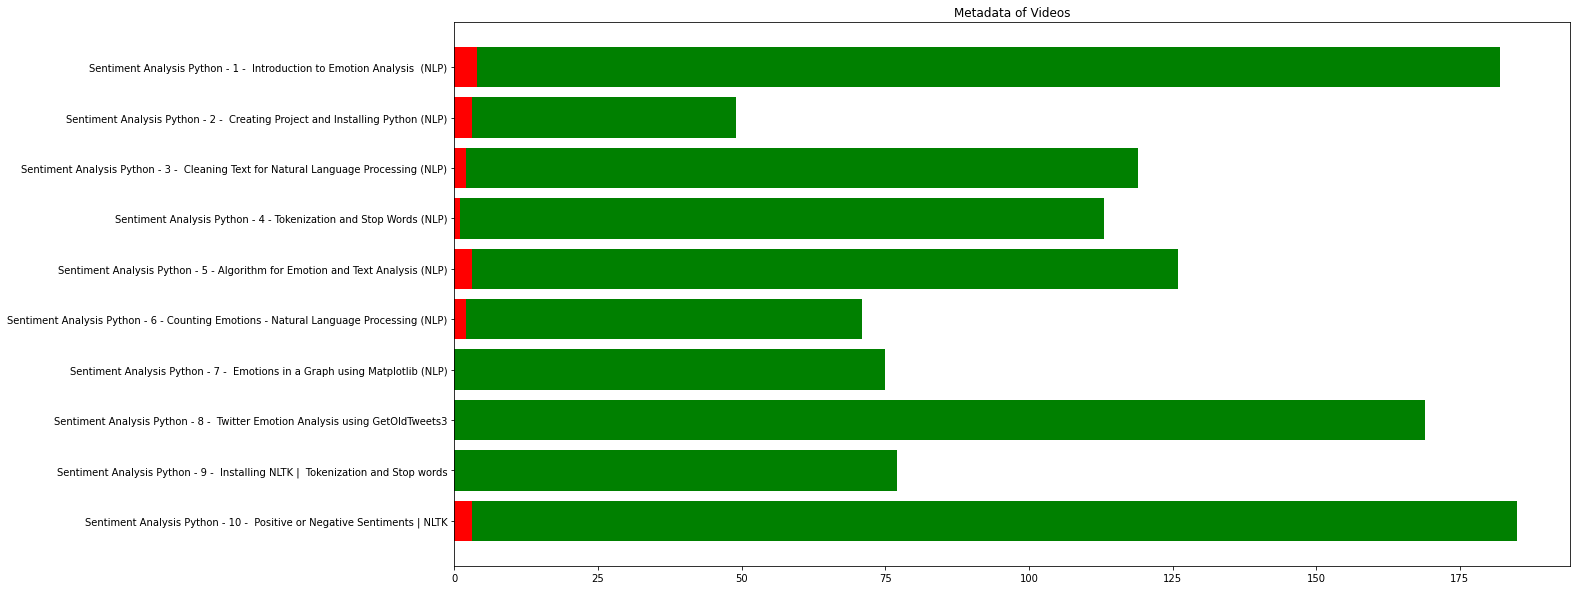

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,10))

ax.barh(video_df['title'], video_df['likes'], color='green', label='likes')
ax.barh(video_df['title'], video_df['dislikes'], color='red', label='dislikes')

ax.set_title("Metadata of Videos")
ax.invert_yaxis();

plt.show()

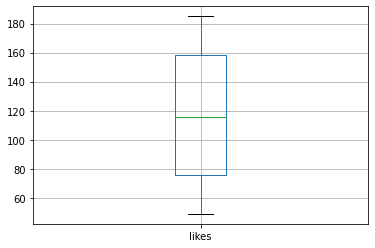

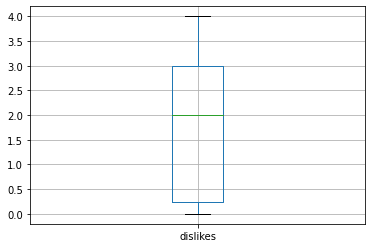

In [5]:
# show boxplot of likes
video_df.boxplot(column='likes')
plt.show()

# show boxplot of dislikes
video_df.boxplot(column='dislikes')
plt.show()

In [6]:
# get comment data

words = []
comments = []
scores = []

with driver.session() as session:
    def _q(query) : return session.run(query)
    #---------------------------------------

    result = _q("MATCH (a:Author)-[c:COMMENTED]->(v:Video) RETURN c")
 
    for record in result:        
        comment_text = ((record['c']['text'].lower())
                    .replace('❤️' , '').replace('💯', '').replace('❤' , '')
                    .replace('🙏', '').replace('😘', '').replace('🤗', '')
                    .replace('💥', '').replace('✔️' , '').replace('😍', '')
                    .replace('🐱', '').replace('💔', '').replace('😵', '') 
                    .replace('😄', '').replace('👍', '').replace('😎', '')
                    .replace('🐷', '').replace('🤘', '').replace('🤣', '')
                    .replace('😩', '').replace('💎', '').replace('😊', '')
                    .replace('☺️' , '').replace('🙃', '').replace('🤔', '')
                    .replace('😂', '').replace('😃', '').replace('🙂', '')
                   
                    .replace('!', '')
                    .replace('?', '')
                    .replace('.', '')
                    .replace(',', '')
                    .replace('=', '')
                    .replace('-', '')
                    .replace(':', '')
                    .replace('*', '')
                    .replace('(', '')
                    .replace(')', '')
                    .replace('\'', '')
                    .replace('    ', ' ').replace('   ', ' ').replace('  ', ' ')
                    .replace('oooo','o').replace('oooo','o').replace('ooo','o').replace('oo','o')
                    .split()
        )
        
        words.extend(comment_text)
        comments.append(comment_text)
        scores.append(float(record['c']['score']))
    
    #---------------------------------------
driver.close()

In [7]:
from pyspark import SparkContext
import nltk

# download necessary files
nltk.download('stopwords')
nltk.download('wordnet')

stemmer = nltk.stem.snowball.EnglishStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()
 
# remove stop words
english_stop_words = nltk.corpus.stopwords.words('english')
english_stop_words.append('u')
print("example english stop words:", english_stop_words[:5])

#words = [stemmer.stem(word) for word in words] # transform each word to root form

sc = SparkContext.getOrCreate()
wordsRDD = sc.parallelize(words, 6)

words_ordered_by_count = (wordsRDD
                .filter(lambda word: not(word in english_stop_words)) # filter out stop words
                .map(lambda word: stemmer.stem(word)) # because nltk is used in pySpark context, it has to be installed as: sudo -H pip install nltk
                .map(lambda word: lemmatizer.lemmatize(word)) # lemmatize each word
                .map(lambda word : (word,1))
                .reduceByKey( lambda a, b : a+b )
                .sortBy(lambda x : x[1]) # sort by word_count
                .takeOrdered(1000, lambda x: -x[1]) # take specific amount descending
         )
sc.stop()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lukashinterleitner/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lukashinterleitner/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


example english stop words: ['i', 'me', 'my', 'myself', 'we']


In [8]:
word_df = pd.DataFrame(words_ordered_by_count, columns=['word', 'count'])

#word_df.head()
print(word_df)

          word  count
0        video     31
1        thank     23
2          use     19
3         emot     16
4         help     15
5         plea     14
6         file     14
7          get     14
8       realli     11
9         code     11
10        much     11
11        like     10
12        nice     10
13        work     10
14       tweet     10
15       error      9
16        word      9
17      tutori      8
18         lot      8
19        text      8
20        make      7
21        keep      7
22         god      7
23        give      7
24     analysi      7
25      python      6
26         bro      6
27        data      6
28        want      6
29       thing      6
30  understand      6
31     project      6
32   sentiment      6
33       creat      6
34       great      6
35        time      6
36     explain      6
37        love      5
38        nltk      5
39      someth      5
40       could      5
41        seri      5
42      differ      5
43        amaz      5
44        

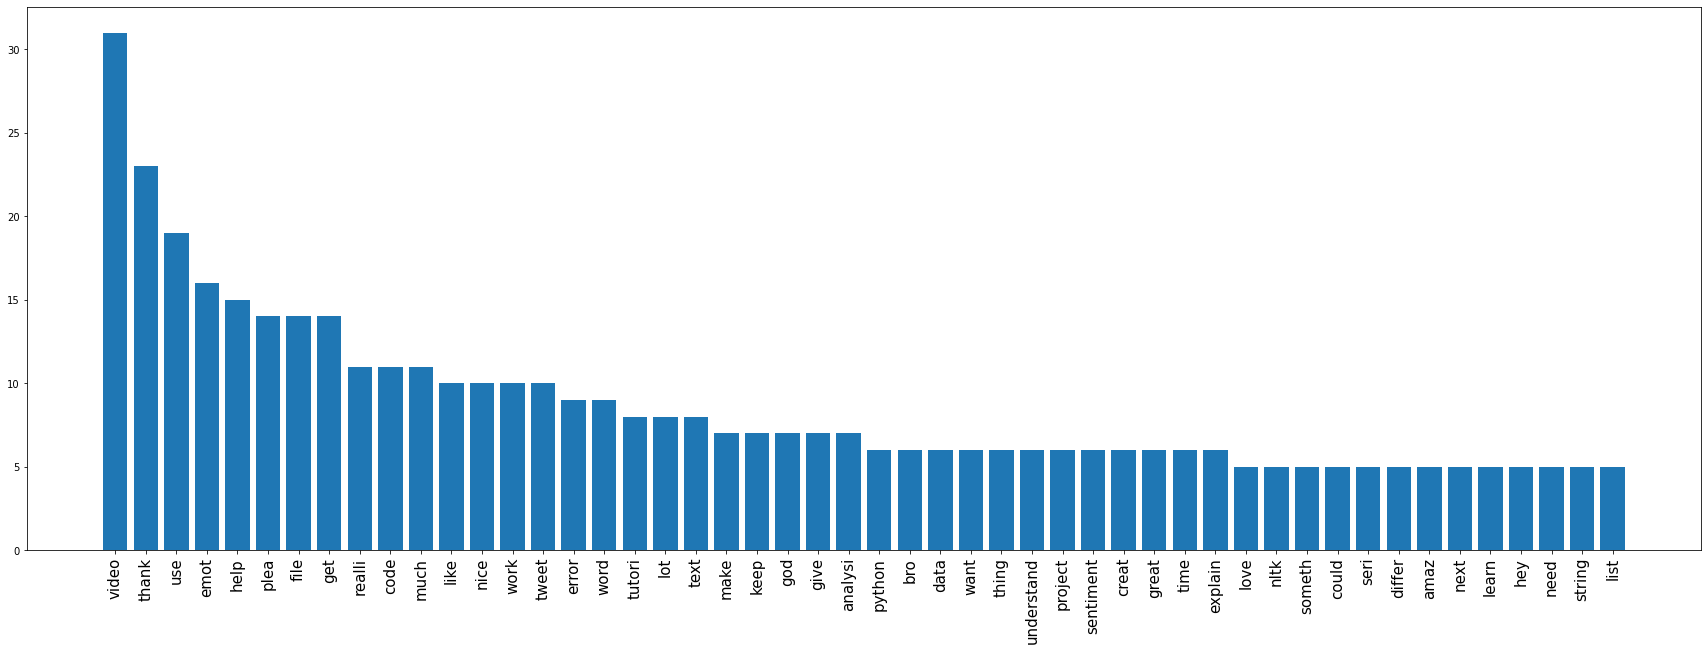

In [9]:
plt.figure(figsize=(30, 10))
plt.bar(word_df['word'], word_df['count'])
plt.xticks(rotation=90, size=15)
plt.show()
